## STEP1 download and prepare the dataset

In [1]:
"""
Build a semantic contennt recommendation system with AWS SageMaker

Data source: 
    20newsgroups dataset contained in scikit-learn package

Usage: 
    The model automatically extract semantic information from the news data, and 
    identify similar news articles from the corpus and provide content recommendations
    for similar news items based on the ones that are selected
    
    The model is trained and deployed in the Amazon SageMaker Notebook instance,
    using built-in algorithms for Neural Topic Model(NTM) and K-Nearest Neighbour(K-NN)

"""
import numpy as np
import os
import matplotlib.pyplot as plt
import sagemaker
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_header, strip_newsgroup_quoting, strip_newsgroup_footer
newsgroups_train = fetch_20newsgroups(subset='train')['data']
newsgroups_test = fetch_20newsgroups(subset = 'test')['data']
NUM_TOPICS = 30
NUM_NEIGHBORS = 10
BUCKET = 'sagemaker-content-recommender'
PREFIX = '20newsgroups'

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.twenty_newsgroups module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
for i in range(len(newsgroups_train)):
    newsgroups_train[i] = strip_newsgroup_header(newsgroups_train[i])
    newsgroups_train[i] = strip_newsgroup_quoting(newsgroups_train[i])
    newsgroups_train[i] = strip_newsgroup_footer(newsgroups_train[i])

In [5]:
newsgroups_train[1]

"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks."

In [6]:
# Tokenize the data to numeric format by assigning a token to each word
# Use WordNetLemmatizer as a lemmatizer from NLTK pacakage
# Use CountVectorizer to perform token counting
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',
                             tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)
vectors = vectorizer.fit_transform(newsgroups_train)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
newidx = np.random.permutation(idx) # this will be the labels fed into the KNN model for training
# Need to store these permutations:

vectors = vectors[newidx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 2000
Done. Time elapsed: 42.63s


In [11]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


In [14]:
# Convert data into training and validation data
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
val_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)

print(train_vectors.shape,val_vectors.shape)

(9051, 2000) (2263, 2000)


In [15]:
# define training and validation path
from sagemaker import get_execution_role

role = get_execution_role()

bucket = BUCKET
prefix = PREFIX

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://sagemaker-content-recommender/20newsgroups/train
Validation set location s3://sagemaker-content-recommender/20newsgroups/val
Trained model will be saved at s3://sagemaker-content-recommender/20newsgroups/output


In [16]:
# convert the raw vectors into RecordIO format, and use n_parts to breaks dataset into shards for destributed training
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://sagemaker-content-recommender/20newsgroups/train/train_part0.pbr
Uploaded data to s3://sagemaker-content-recommender/20newsgroups/train/train_part1.pbr
Uploaded data to s3://sagemaker-content-recommender/20newsgroups/train/train_part2.pbr
Uploaded data to s3://sagemaker-content-recommender/20newsgroups/train/train_part3.pbr
Uploaded data to s3://sagemaker-content-recommender/20newsgroups/train/train_part4.pbr
Uploaded data to s3://sagemaker-content-recommender/20newsgroups/train/train_part5.pbr
Uploaded data to s3://sagemaker-content-recommender/20newsgroups/train/train_part6.pbr
Uploaded data to s3://sagemaker-content-recommender/20newsgroups/train/train_part7.pbr
Uploaded data to s3://sagemaker-content-recommender/20newsgroups/val/val_part0.pbr


## STEP2 Train and deploy the topic model

#### create and run the training job
The built in algorithms are stored as docker conatiners in Amazon ECR, need to specify container and region

In [17]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'ntm')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [18]:
# Use estimator to specify the infrastructure for model training
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=2, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)
# set the hyperparamter
ntm.set_hyperparameters(num_topics=NUM_TOPICS, feature_dim=vocab_size, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

Use ShardedBys3Key to spread data to different workers, each worker receives a different portion of the full data set, this method is more efficient that FullyReplicated data.

In [19]:
# Model Training, the topic model is trained with the NTM algorithms
from sagemaker.session import s3_input
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key') 
ntm.fit({'train': s3_train, 'test': s3_val_data})

2020-06-28 21:11:57 Starting - Starting the training job...
2020-06-28 21:12:02 Starting - Launching requested ML instances.........
2020-06-28 21:13:28 Starting - Preparing the instances for training...............
2020-06-28 21:16:26 Downloading - Downloading input data...
2020-06-28 21:16:59 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[06/28/2020 21:17:14 INFO 140483679958848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': 

[2020-06-28 21:17:25.199] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 1318, "num_examples": 36, "num_bytes": 1045376}
[06/28/2020 21:17:25 INFO 140483679958848] # Finished training epoch 2 on 4524 examples from 36 batches, each of size 128.
[06/28/2020 21:17:25 INFO 140483679958848] Metrics for Training:
[06/28/2020 21:17:25 INFO 140483679958848] Loss (name: value) total: 6.86405001084
[06/28/2020 21:17:25 INFO 140483679958848] Loss (name: value) kld: 0.00216994716579
[06/28/2020 21:17:25 INFO 140483679958848] Loss (name: value) recons: 6.86188005077
[06/28/2020 21:17:25 INFO 140483679958848] Loss (name: value) logppx: 6.86405001084
[06/28/2020 21:17:25 INFO 140483679958848] #quality_metric: host=algo-1, epoch=2, train total_loss <loss>=6.86405001084
[06/28/2020 21:17:25 INFO 140483679958848] Timing: train: 1.32s, val: 0.00s, epoch: 1.32s
[06/28/2020 21:17:25 INFO 140483679958848] #progress_metric: host=algo-1, completed 2 % of ep

[2020-06-28 21:17:34.984] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 1230, "num_examples": 36, "num_bytes": 1045376}
[06/28/2020 21:17:34 INFO 140483679958848] # Finished training epoch 10 on 4524 examples from 36 batches, each of size 128.
[06/28/2020 21:17:34 INFO 140483679958848] Metrics for Training:
[06/28/2020 21:17:34 INFO 140483679958848] Loss (name: value) total: 6.84635975626
[06/28/2020 21:17:34 INFO 140483679958848] Loss (name: value) kld: 0.0147634430064
[06/28/2020 21:17:34 INFO 140483679958848] Loss (name: value) recons: 6.83159632815
[06/28/2020 21:17:34 INFO 140483679958848] Loss (name: value) logppx: 6.84635975626
[06/28/2020 21:17:34 INFO 140483679958848] #quality_metric: host=algo-1, epoch=10, train total_loss <loss>=6.84635975626
[06/28/2020 21:17:34 INFO 140483679958848] patience losses:[6.855546686384413, 6.854756931463878, 6.851365016566382, 6.848197897275289, 6.8477046092351275] min patience loss:6.84770

[2020-06-28 21:17:44.374] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 53, "duration": 1161, "num_examples": 36, "num_bytes": 1045376}
[06/28/2020 21:17:44 INFO 140483679958848] # Finished training epoch 18 on 4524 examples from 36 batches, each of size 128.
[06/28/2020 21:17:44 INFO 140483679958848] Metrics for Training:
[06/28/2020 21:17:44 INFO 140483679958848] Loss (name: value) total: 6.76773350769
[06/28/2020 21:17:44 INFO 140483679958848] Loss (name: value) kld: 0.054659607458
[06/28/2020 21:17:44 INFO 140483679958848] Loss (name: value) recons: 6.71307391591
[06/28/2020 21:17:44 INFO 140483679958848] Loss (name: value) logppx: 6.76773350769
[06/28/2020 21:17:44 INFO 140483679958848] #quality_metric: host=algo-1, epoch=18, train total_loss <loss>=6.76773350769
[06/28/2020 21:17:44 INFO 140483679958848] patience losses:[6.836433748404185, 6.830780426661174, 6.813635839356317, 6.7989399962955055, 6.782559427950117] min patience loss:6.782559

[2020-06-28 21:17:53.549] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 74, "duration": 1175, "num_examples": 36, "num_bytes": 1057504}
[06/28/2020 21:17:53 INFO 140435207169856] # Finished training epoch 25 on 4527 examples from 36 batches, each of size 128.
[06/28/2020 21:17:53 INFO 140435207169856] Metrics for Training:
[06/28/2020 21:17:53 INFO 140435207169856] Loss (name: value) total: 6.73203800122
[06/28/2020 21:17:53 INFO 140435207169856] Loss (name: value) kld: 0.0762096454079
[06/28/2020 21:17:53 INFO 140435207169856] Loss (name: value) recons: 6.65582833025
[06/28/2020 21:17:53 INFO 140435207169856] Loss (name: value) logppx: 6.73203800122
[06/28/2020 21:17:53 INFO 140435207169856] #quality_metric: host=algo-2, epoch=25, train total_loss <loss>=6.73203800122
[06/28/2020 21:17:53 INFO 140435207169856] patience losses:[6.765434576405419, 6.757360809379154, 6.749419550100963, 6.746335943539937, 6.742022156715393] min patience loss:6.742022

[2020-06-28 21:18:05.500] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 107, "duration": 1206, "num_examples": 36, "num_bytes": 1045376}
[06/28/2020 21:18:05 INFO 140483679958848] # Finished training epoch 36 on 4524 examples from 36 batches, each of size 128.
[06/28/2020 21:18:05 INFO 140483679958848] Metrics for Training:
[06/28/2020 21:18:05 INFO 140483679958848] Loss (name: value) total: 6.67294475105
[06/28/2020 21:18:05 INFO 140483679958848] Loss (name: value) kld: 0.10592392118
[06/28/2020 21:18:05 INFO 140483679958848] Loss (name: value) recons: 6.56702084674
[06/28/2020 21:18:05 INFO 140483679958848] Loss (name: value) logppx: 6.67294475105
[06/28/2020 21:18:05 INFO 140483679958848] #quality_metric: host=algo-1, epoch=36, train total_loss <loss>=6.67294475105
[06/28/2020 21:18:05 INFO 140483679958848] patience losses:[6.690232124593523, 6.690478536817762, 6.682900501622094, 6.676800151666005, 6.676695863405864] min patience loss:6.6766958

[2020-06-28 21:18:16.004] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 134, "duration": 1212, "num_examples": 36, "num_bytes": 1045376}
[06/28/2020 21:18:16 INFO 140483679958848] # Finished training epoch 45 on 4524 examples from 36 batches, each of size 128.
[06/28/2020 21:18:16 INFO 140483679958848] Metrics for Training:
[06/28/2020 21:18:16 INFO 140483679958848] Loss (name: value) total: 6.63044397699
[06/28/2020 21:18:16 INFO 140483679958848] Loss (name: value) kld: 0.128240561527
[06/28/2020 21:18:16 INFO 140483679958848] Loss (name: value) recons: 6.50220341153
[06/28/2020 21:18:16 INFO 140483679958848] Loss (name: value) logppx: 6.63044397699
[06/28/2020 21:18:16 INFO 140483679958848] #quality_metric: host=algo-1, epoch=45, train total_loss <loss>=6.63044397699
[06/28/2020 21:18:16 INFO 140483679958848] patience losses:[6.655215508408016, 6.647549615965949, 6.643121454450819, 6.642489751180013, 6.633239441447788] min patience loss:6.633239

[2020-06-28 21:18:26.536] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 161, "duration": 1154, "num_examples": 36, "num_bytes": 1045376}
[06/28/2020 21:18:26 INFO 140483679958848] # Finished training epoch 54 on 4524 examples from 36 batches, each of size 128.
[06/28/2020 21:18:26 INFO 140483679958848] Metrics for Training:
[06/28/2020 21:18:26 INFO 140483679958848] Loss (name: value) total: 6.5937852727
[06/28/2020 21:18:26 INFO 140483679958848] Loss (name: value) kld: 0.148663871301
[06/28/2020 21:18:26 INFO 140483679958848] Loss (name: value) recons: 6.44512144062
[06/28/2020 21:18:26 INFO 140483679958848] Loss (name: value) logppx: 6.5937852727
[06/28/2020 21:18:26 INFO 140483679958848] #quality_metric: host=algo-1, epoch=54, train total_loss <loss>=6.5937852727
[06/28/2020 21:18:26 INFO 140483679958848] patience losses:[6.617252780331506, 6.603566136625078, 6.609585185845693, 6.598415169450972, 6.599101417594486] min patience loss:6.598415169

[2020-06-28 21:18:34.657] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 176, "duration": 1193, "num_examples": 36, "num_bytes": 1057504}
[06/28/2020 21:18:34 INFO 140435207169856] # Finished training epoch 59 on 4527 examples from 36 batches, each of size 128.
[06/28/2020 21:18:34 INFO 140435207169856] Metrics for Training:
[06/28/2020 21:18:34 INFO 140435207169856] Loss (name: value) total: 6.58031282822
[06/28/2020 21:18:34 INFO 140435207169856] Loss (name: value) kld: 0.163108282619
[06/28/2020 21:18:34 INFO 140435207169856] Loss (name: value) recons: 6.41720456547
[06/28/2020 21:18:34 INFO 140435207169856] Loss (name: value) logppx: 6.58031282822
[06/28/2020 21:18:34 INFO 140435207169856] #quality_metric: host=algo-2, epoch=59, train total_loss <loss>=6.58031282822
[06/28/2020 21:18:34 INFO 140435207169856] patience losses:[6.59336253007253, 6.591497745778826, 6.581901205910577, 6.58040835460027, 6.579199135303497] min patience loss:6.57919913

[2020-06-28 21:18:45.648] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 203, "duration": 1221, "num_examples": 36, "num_bytes": 1057504}
[06/28/2020 21:18:45 INFO 140435207169856] # Finished training epoch 68 on 4527 examples from 36 batches, each of size 128.
[06/28/2020 21:18:45 INFO 140435207169856] Metrics for Training:
[06/28/2020 21:18:45 INFO 140435207169856] Loss (name: value) total: 6.55095266634
[06/28/2020 21:18:45 INFO 140435207169856] Loss (name: value) kld: 0.183260036425
[06/28/2020 21:18:45 INFO 140435207169856] Loss (name: value) recons: 6.36769267586
[06/28/2020 21:18:45 INFO 140435207169856] Loss (name: value) logppx: 6.55095266634
[06/28/2020 21:18:45 INFO 140435207169856] #quality_metric: host=algo-2, epoch=68, train total_loss <loss>=6.55095266634
[06/28/2020 21:18:45 INFO 140435207169856] patience losses:[6.559609088632795, 6.56524967485004, 6.548815647761027, 6.553648451964061, 6.555119660165575] min patience loss:6.5488156

[06/28/2020 21:18:55 INFO 140435207169856] patience losses:[6.536170727676815, 6.53855433066686, 6.53166878885693, 6.528262237707774, 6.536987271573809] min patience loss:6.52826223771 current loss:6.52796909544 absolute loss difference:0.000293142265744
[06/28/2020 21:18:55 INFO 140435207169856] Bad epoch: loss has not improved (enough). Bad count:2
[06/28/2020 21:18:55 INFO 140435207169856] Timing: train: 1.21s, val: 0.00s, epoch: 1.21s
[06/28/2020 21:18:55 INFO 140435207169856] #progress_metric: host=algo-2, completed 76 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 36, "sum": 36.0, "min": 36}, "Number of Batches Since Last Reset": {"count": 1, "max": 36, "sum": 36.0, "min": 36}, "Number of Records Since Last Reset": {"count": 1, "max": 4527, "sum": 4527.0, "min": 4527}, "Total Batches Seen": {"count": 1, "max": 2736, "sum": 2736.0, "min": 2736}, "Total Records Seen": {"count": 1, "max": 344052, "sum": 344052.0, "min": 344052}, "Max Records

[2020-06-28 21:19:08.085] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 266, "duration": 1214, "num_examples": 36, "num_bytes": 1045376}
[06/28/2020 21:19:08 INFO 140483679958848] # Finished training epoch 89 on 4524 examples from 36 batches, each of size 128.
[06/28/2020 21:19:08 INFO 140483679958848] Metrics for Training:
[06/28/2020 21:19:08 INFO 140483679958848] Loss (name: value) total: 6.50061796771
[06/28/2020 21:19:08 INFO 140483679958848] Loss (name: value) kld: 0.217592530159
[06/28/2020 21:19:08 INFO 140483679958848] Loss (name: value) recons: 6.28302543031
[06/28/2020 21:19:08 INFO 140483679958848] Loss (name: value) logppx: 6.50061796771
[06/28/2020 21:19:08 INFO 140483679958848] #quality_metric: host=algo-1, epoch=89, train total_loss <loss>=6.50061796771
[06/28/2020 21:19:08 INFO 140483679958848] patience losses:[6.506818791230519, 6.504571908050114, 6.507675376203325, 6.507235096560584, 6.501663724581401] min patience loss:6.501663


2020-06-28 21:19:27 Uploading - Uploading generated training model[2020-06-28 21:19:18.577] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 284, "duration": 1182, "num_examples": 36, "num_bytes": 1057504}
[06/28/2020 21:19:18 INFO 140435207169856] # Finished training epoch 95 on 4527 examples from 36 batches, each of size 128.
[06/28/2020 21:19:18 INFO 140435207169856] Metrics for Training:
[06/28/2020 21:19:18 INFO 140435207169856] Loss (name: value) total: 6.49992576573
[06/28/2020 21:19:18 INFO 140435207169856] Loss (name: value) kld: 0.224718533663
[06/28/2020 21:19:18 INFO 140435207169856] Loss (name: value) recons: 6.27520721489
[06/28/2020 21:19:18 INFO 140435207169856] Loss (name: value) logppx: 6.49992576573
[06/28/2020 21:19:18 INFO 140435207169856] #quality_metric: host=algo-2, epoch=95, train total_loss <loss>=6.49992576573
[06/28/2020 21:19:18 INFO 140435207169856] patience losses:[6.502364377180736, 6.498775959014893, 6.49625845087899


2020-06-28 21:19:34 Completed - Training job completed
Training seconds: 376
Billable seconds: 376


### deploy the topic model

two ways to deploy the model:
1. Create one inference at a time, set up a persistent endpoint using SageMaker hosting services
2. To get inferences for an entire dataset, use SageMaker batch transform

In [24]:
# deploy the topic model with batch transform
np.savetxt('trainvectors.csv',
           vectors.todense(),
           delimiter=',',
           fmt='%i')
batch_prefix = '20newsgroups/batch'

train_s3 = sess.upload_data('trainvectors.csv', 
                            bucket=bucket, 
                            key_prefix='{}/train'.format(batch_prefix))
print(train_s3)
batch_output_path = 's3://{}/{}/test'.format(bucket, batch_prefix)

ntm_transformer = ntm.transformer(instance_count=1,
                                  instance_type ='ml.m4.xlarge',
                                  output_path=batch_output_path
                                 )
ntm_transformer.transform(train_s3, content_type='text/csv', split_type='Line')
ntm_transformer.wait()

s3://sagemaker-content-recommender/20newsgroups/batch/train/trainvectors.csv


.....................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[06/28/2020 21:36:18 INFO 140092981241664] loaded entry point class algorithm.serve.server_config:config_api
[06/28/2020 21:36:18 INFO 140092981241664] loading entry points
/opt/amazon/lib/python2.7/site-packages/ai_algorithms_sdk/serve.py:195: DeprecationWarning: entrypoint algorithm.request_iterators is deprecated in favor of algorithm.io.data_handlers.serve
  "in favor of algorithm.io.data_handlers.serve", DeprecationWarning)
[06/28/2020 21:36:18 INFO 140092981241664] loaded request iterator text/csv
[06/28/2020 21:36:18 INFO 140092981241664] loaded request iterator application/x-recordio-protobuf
[06/28/2020 21:36:18 INFO 140092981241664] loaded req

In [25]:
# Option B: Use SageMaker hosting service

# ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


# Ensure that the input payload is seralized in a machine readable format and the output is deserialized into a 
# human readbale format
# from sagemaker.predictor import csv_serializer, json_deserializer

# ntm_predictor.content_type = 'text/csv'
# ntm_predictor.serializer = csv_serializer
# ntm_predictor.deserializer = json_deserializer

# Extract the topic vectors for the training data that we use in the K-NN model
# predictions = []
# for item in np.array(vectors.todense()):
#     np.shape(item)
#     results = ntm_predictor.predict(item)
#     predictions.append(np.array([prediction['topic_weights'] for prediction in results['predictions']]))
    
# predictions = np.array([np.ndarray.flatten(x) for x in predictions])
# topicvec = train_labels[newidx]
# topicnames = [categories[x] for x in topicvec]


### Explore the topic model

Use the T-SNE(Distributed Stocahstic Neighbour Embedding) plot to visualize the topic vectors

The T-SNE is a non-linear technique for dimensionality reduction which aims to ensure that the distance between nearest neighbors in the original high dimensional space is preserved in the resulting lower dimensional space.

Setting the number of dimensions to 2 so that we could visualize the topic in 2D space

In [29]:
from sklearn.manifold import TSNE
import pandas as pd
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000)
tsne_results = tsne.fit_transform(predictions)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsnedf = pd.DataFrame()
tsnedf['tsne-2d-one'] = tsne_results[:,0]
tsnedf['tsne-2d-two'] = tsne_results[:,1]
tsnedf['Topic']=topicnames
plt.figure(figsize=(25,25))
sns.lmplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Topic',
    palette=sns.color_palette("hls", NUM_TOPICS),
    data=tsnedf,
    legend="full",
    fit_reg=False
)
plt.axis('Off')
plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.038s...
[t-SNE] Computed neighbors for 11314 samples in 3.619s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergenc

NameError: name 'topicnames' is not defined

## STEP3 train and deploy the content recommendation model

In [31]:
# create a dictionary which links the shuffled labels to the original labels in the trainin data
labels = newidx 
labeldict = dict(zip(newidx,idx))

In [32]:
# store the training data in S3 bucket
import io
import sagemaker.amazon.common as smac


print('train_features shape = ', predictions.shape)
print('train_labels shape = ', labels.shape)
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, predictions, labels)
buf.seek(0)

bucket = BUCKET
prefix = PREFIX
key = 'knn/train'
fname = os.path.join(prefix, key)
print(fname)
boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

train_features shape =  (11314, 30)
train_labels shape =  (11314,)
20newsgroups/knn/train
uploaded training data location: s3://sagemaker-content-recommender/20newsgroups/knn/train


### create a K-NN estimator

The model will be trained to return the nearest neighbors given a particular test topic

In [33]:
def trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path, s3_test_data=None):
    """
    Create an Estimator from the given hyperparams, fit to training data, 
    and return a deployed predictor
    
    """
    # set up the estimator
    knn = sagemaker.estimator.Estimator(get_image_uri(boto3.Session().region_name, "knn"),
        get_execution_role(),
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker.Session())
    knn.set_hyperparameters(**hyperparams)
    
    # train a model. fit_input contains the locations of the train and test data
    fit_input = {'train': s3_train_data}
    knn.fit(fit_input)
    return knn

hyperparams = {
    'feature_dim': predictions.shape[1],
    'k': NUM_NEIGHBORS,
    'sample_size': predictions.shape[0],
    'predictor_type': 'classifier' ,
    'index_metric':'COSINE'
}
output_path = 's3://' + bucket + '/' + prefix + '/knn/output'
knn_estimator = trained_estimator_from_hyperparams(s3_train_data, hyperparams, output_path)

2020-06-28 21:57:14 Starting - Starting the training job...
2020-06-28 21:57:16 Starting - Launching requested ML instances......
2020-06-28 21:58:43 Starting - Preparing the instances for training......
2020-06-28 21:59:29 Downloading - Downloading input data......
2020-06-28 22:00:36 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/28/2020 22:00:39 INFO 139742945994560] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[06/28/2020 22:00:39 INFO 139742945994560] Merging with provided configuration from /opt/


2020-06-28 22:00:53 Uploading - Uploading generated training model
2020-06-28 22:00:53 Completed - Training job completed
Training seconds: 84
Billable seconds: 84


### Deploy the content recommendation model
The k_NN model will return all the cosine distances 
To build the engine, we need to get top-k suggestions from the engine

In [34]:
def predictor_from_estimator(knn_estimator, estimator_name, instance_type, endpoint_name=None): 
    knn_predictor = knn_estimator.deploy(initial_instance_count=1, instance_type=instance_type,
                                        endpoint_name=endpoint_name,
                                        accept="application/jsonlines; verbose=true")
    knn_predictor.content_type = 'text/csv'
    knn_predictor.serializer = csv_serializer
    knn_predictor.deserializer = json_deserializer
    return knn_predictor
import time

instance_type = 'ml.m4.xlarge'
model_name = 'knn_%s'% instance_type
endpoint_name = 'knn-ml-m4-xlarge-%s'% (str(time.time()).replace('.','-'))
print('setting up the endpoint..')
knn_predictor = predictor_from_estimator(knn_estimator, model_name, instance_type, endpoint_name=endpoint_name)

setting up the endpoint..
-------------!

In [35]:
# process the test data so that you can run inferences
def preprocess_input(text):
    text = strip_newsgroup_header(text)
    text = strip_newsgroup_quoting(text)
    text = strip_newsgroup_footer(text)
    return text    
    
test_data_prep = []
for i in range(len(newsgroups_test)):
    test_data_prep.append(preprocess_input(newsgroups_test[i]))
test_vectors = vectorizer.fit_transform(test_data_prep)

test_vectors = np.array(test_vectors.todense())
test_topics = []
for vec in test_vectors:
    test_result = ntm_predictor.predict(vec)
    test_topics.append(test_result['predictions'][0]['topic_weights'])

topic_predictions = []
for topic in test_topics:
    result = knn_predictor.predict(topic)
    cur_predictions = np.array([int(result['labels'][i]) for i in range(len(result['labels']))])
    topic_predictions.append(cur_predictions[::-1][:10]) 

### Explore content recommendation model

Now that the predictions are obtained. Plot the topics distributions of the 
test topics, compared to the closest K topics recommedned by the k-NN model

In [36]:
# set your own k.
def plot_topic_distribution(topic_num, k = 5):
    
    closest_topics = [predictions[labeldict[x]] for x in topic_predictions[topic_num][:k]]
    closest_topics.append(np.array(test_topics[topic_num]))
    closest_topics = np.array(closest_topics)
    df = pd.DataFrame(closest_topics.T)
    df.rename(columns ={k:"Test Document Distribution"}, inplace=True)
    fs = 12
    df.plot(kind='bar', figsize=(16,4), fontsize=fs)
    plt.ylabel('Topic assignment', fontsize=fs+2)
    plt.xlabel('Topic ID', fontsize=fs+2)
    plt.show()

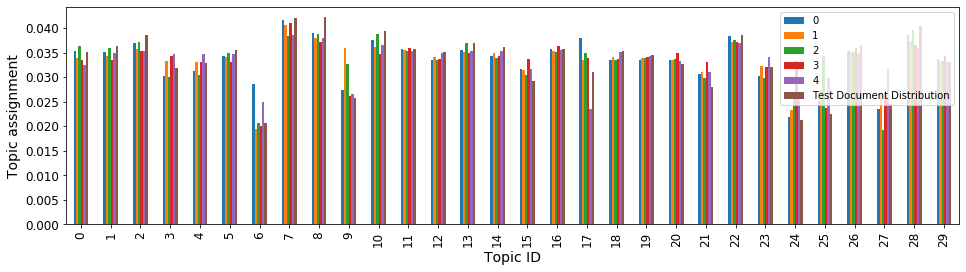

In [37]:
plot_topic_distribution(18)

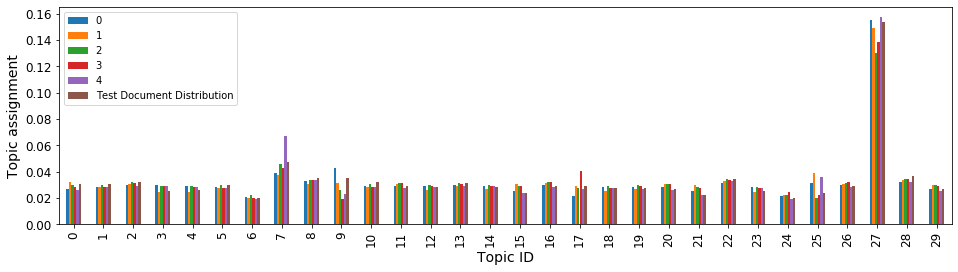

In [38]:
plot_topic_distribution(25)

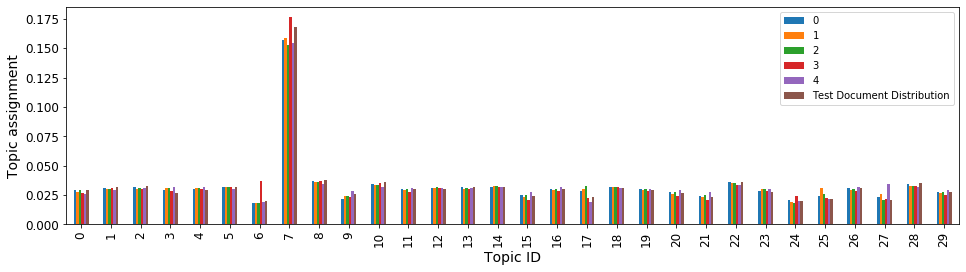

In [39]:
plot_topic_distribution(5000)

## Cleanup



In [40]:
ntm_predictor.delete_endpoint()
knn_predictor.delete_endpoint()